# Libarary Import

In [1]:
import os
import os.path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

from sklearn.metrics import f1_score

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = '/opt/ml/input/data/train'

In [3]:
train_data = pd.read_csv(os.path.join(train_path, 'train.csv'))

In [4]:
train_data.head(5)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


# Data Info

### 성별 비율

0.3859259259259259
0.614074074074074


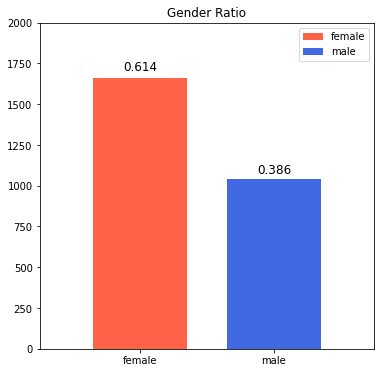

In [6]:
gender = train_data["gender"].unique()
value = train_data["gender"].value_counts()

fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
ax.bar(gender[0], value[0], width=0.7, color='tomato', label=gender[0])
ax.bar(gender[1], value[1], width=0.7, color='royalblue', label=gender[1])
ax.text(gender[0], value[0]*1.03, f"{value[0]/value.sum():.3f}", fontsize=12, horizontalalignment='center')
ax.text(gender[1], value[1]*1.03, f"{value[1]/value.sum():.3f}", fontsize=12, horizontalalignment='center')
ax.set_ylim(0, 2000)
ax.set_xlim(-0.75, 1.75)
ax.set_title("Gender Ratio")
ax.legend()

print(f"{1 - (value[0]/value.sum())}")
print(f"{1 - (value[1]/value.sum())}")

### 성별 연령대

0.5255555555555556
0.5455555555555556
0.9288888888888889


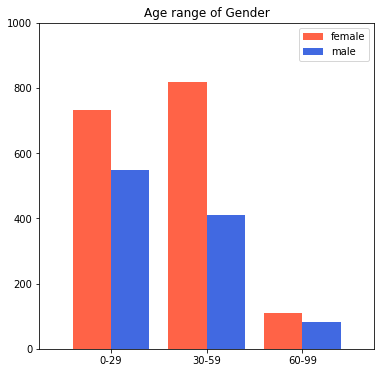

In [7]:
male = train_data[train_data["gender"] == "male"]
female = train_data[train_data["gender"] == "female"]

male_0_30 = (male["age"] < 30).sum()
male_30_60 = ((male["age"] >= 30) & (male["age"] < 60)).sum()
male_60 = (male["age"] >= 60).sum()

female_0_30 = (female["age"] < 30).sum()
female_30_60 = ((female["age"] >= 30) & (female["age"] < 60)).sum()
female_60 = (female["age"] >= 60).sum()

age_0_30 = male_0_30 + female_0_30
age_30_60 = male_30_60 + female_30_60
age_60 = male_60 + female_60

total = age_0_30 + age_30_60 + age_60

cnt_male = np.array([male_0_30, male_30_60, male_60])
cnt_female = np.array([female_0_30, female_30_60, female_60])

fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
ax.bar(np.arange(3)-0.4/2, cnt_female, width=0.4, color="tomato", label=gender[0])
ax.bar(np.arange(3)+0.4/2, cnt_male, width=0.4, color="royalblue", label=gender[1])

ax.set_ylim(0, 1000)
ax.set_xlim(-0.75, 2.75)
ax.set_xticks(range(3))
ax.set_xticklabels(["0-29", "30-59", "60-99"])
ax.set_title("Age range of Gender")
ax.legend()

print(f"{1 - (age_0_30 / total)}")
print(f"{1 - (age_30_60 / total)}")
print(f"{1 - (age_60 / total)}")

### 연령대 분포

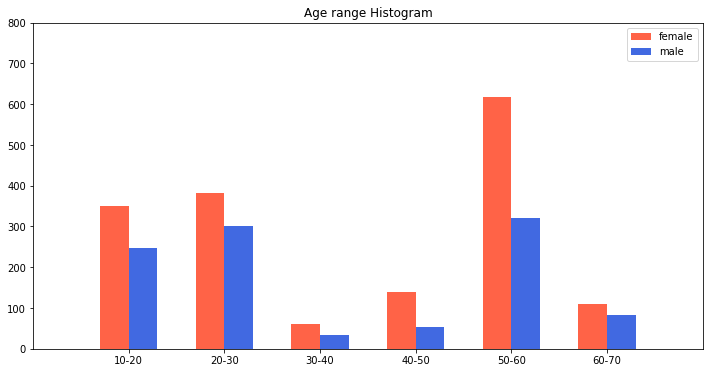

In [8]:
female_hist_arr, female_bin_arr = np.histogram(female["age"], [0, 10, 20, 30, 40, 50, 60, 70])
male_hist_arr, male_bin_arr = np.histogram(male["age"], [0, 10, 20, 30, 40, 50, 60, 70])

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=1)
ax.bar(female_bin_arr[:-1]-3/2, female_hist_arr, width=3, color="tomato", label=gender[0])
ax.bar(male_bin_arr[:-1]+3/2, male_hist_arr, width=3, color="royalblue", label=gender[1])
ax.set_xlim(0, 70)
ax.set_ylim(0, 800)
ax.set_xticks(range(10, 70, 10))
ax.set_xticklabels(["10-20", "20-30", "30-40", "40-50", "50-60", "60-70"])
ax.set_title("Age range Histogram")
ax.legend()

# Data, Label

In [9]:
base_path = '/opt/ml/input/data/train/images'

/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg
10
18900


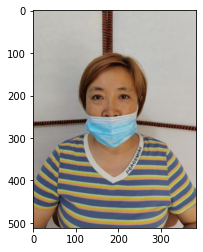

In [10]:
train_path = []
train_label = []
mask_label = []
gender_label = []
age_label = []

for p in train_data['path']:
    _, gender, _, age = p.split('_')
    
    path = os.path.join(base_path, p)
    num = 0
    
    age_num = 0
    if (int(age) >= 30) & (int(age) < 60):
        num += 1
        age_num = 1
    elif int(age) >= 60:
        num += 2
        age_num = 2
        
    gender_num = 0
    if gender == 'female':
        num += 3
        gender_num = 1
        
    
    for s in glob.glob(path + '/*'):
        name = s.split(os.sep)[-1]
        if name.find('incorrect') == 0:
            train_path.append(os.path.join(path, name))
            train_label.append(num+6)
            mask_label.append(1)
            gender_label.append(gender_num)
            age_label.append(age_num)
        elif name.find('mask') == 0:
            train_path.append(os.path.join(path, name))
            train_label.append(num)
            mask_label.append(0)
            gender_label.append(gender_num)
            age_label.append(age_num)
        elif name.find('normal') == 0:
            train_path.append(os.path.join(path, name))
            train_label.append(num+12)
            mask_label.append(2)
            gender_label.append(gender_num)
            age_label.append(age_num)
        
print(train_path[0])
print(train_label[0])
print(len(train_path))
plt.imshow(Image.open(train_path[0]))

[0 1 2] [13500  2700  2700]
[0 1] [ 7294 11606]
[0 1 2] [8967 8589 1344]


Text(0.5, 1.0, 'Class Histogram')

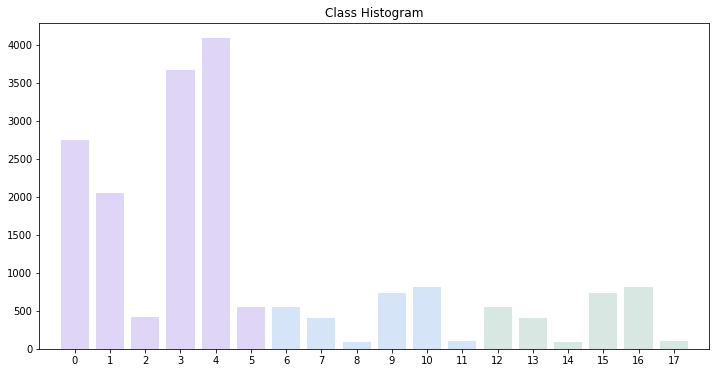

In [11]:
label, label_cnt = np.unique(train_label, return_counts=True)
mask, mask_cnt = np.unique(mask_label, return_counts=True)
gender, gender_cnt = np.unique(gender_label, return_counts=True)
age, age_cnt = np.unique(age_label, return_counts=True)

print(mask, mask_cnt)
print(gender, gender_cnt)
print(age, age_cnt)

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=1)
ax.bar(label, label_cnt, color=(['#dfd6f7']*6)+(['#d5e4f7']*6)+(['#d8e7e2']*6))
ax.set_xlim(-1, 18)
ax.set_xticks(range(18))
ax.set_xticklabels(range(18))
ax.set_title("Class Histogram")

# Model

In [14]:
timm.list_models('resnet*', pretrained=True)

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200d',
 'resnetaa50',
 'resnetblur50',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d_evos',
 'resnetv2_50d_gn',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_50x1_bitm',
 'resnetv2_50x1_bitm_in21k',
 'resnetv2_50x3_bitm',
 'resnetv2_50x3_bitm_in21k',
 'resnetv2_101',
 'resnetv2_101x1_bitm',
 'resnetv2_101x1_bitm_in21k',
 'resnetv2_101x3_bitm',
 'resnetv2_101x3_bitm_in21k',
 'resnetv2_152x2_bit_teacher',
 'resnetv2_152x2_bit_teacher_384',
 'resnetv2_152x2_bitm',
 'resnetv2_152x2_bitm_in21k',
 'resnetv2_152x4_bitm',
 'resnetv2_152x4_bitm_in21k']

In [15]:
model = timm.create_model('resnet50', pretrained=True, num_classes=8)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [16]:
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(out.shape)

torch.Size([1, 8])


# DataSet

In [17]:
class TrainDataset(Dataset):
    def __init__(self, images, labels, mask, gender, age, transform, multi_label=False):
        self.images = images
        self.labels = labels
        self.mask = mask
        self.gender = gender
        self.age = age
        self.transform = transform
        self.multi_label = multi_label
    
    def __getitem__(self, idx):
        
        if self.transform != None:
            image = self.transform(image=np.array(Image.open(self.images[idx])))
        
        label = 0
        if self.multi_label:
            label = (self.mask[idx], self.gender[idx], self.age[idx])
        else:
            label = self.labels[idx]
        
        return image["image"], label
    
    def __len__(self):
        return len(self.images)

class TestDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform
    
    def __getitem__(self, idx):
        
        if self.transform != None:
            image = self.transform(image=np.array(Image.open(self.images[idx])))
        
        return image["image"]
    
    def __len__(self):
        return len(self.images)

In [30]:
# train_transform = transforms.Compose([
#     transforms.CenterCrop(320),
#     transforms.Resize(224),
#     transforms.RandomHorizontalFlip(p=0.5),
#     ToTensor(),
#     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# ])

train_transform = A.Compose([
    A.CenterCrop(320, 320, p=1),
    #A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Cutout(num_holes=80, max_h_size=32, max_w_size=32, fill_value=0, p=1),
    A.Normalize(p=1),
    ToTensorV2()
])
# patch num : 196
# mask(0.75) : 147
# mask(0.50) : 98
# mask(0.25) : 49

# test_transform = transforms.Compose([
#     transforms.CenterCrop(320),
#     transforms.Resize(224),
#     ToTensor(),
#     Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# ])

test_transform = A.Compose([
    A.CenterCrop(320, 320, p=1),
    A.Normalize(p=1),
    ToTensorV2()
])

/opt/ml/WorkSpace/test_space/.venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [31]:
train_dataset = TrainDataset(train_path, train_label, mask_label, gender_label, age_label, train_transform, multi_label=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

submission = pd.read_csv('/opt/ml/input/data/eval/info.csv')
image_dir = '/opt/ml/input/data/eval/images'

image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

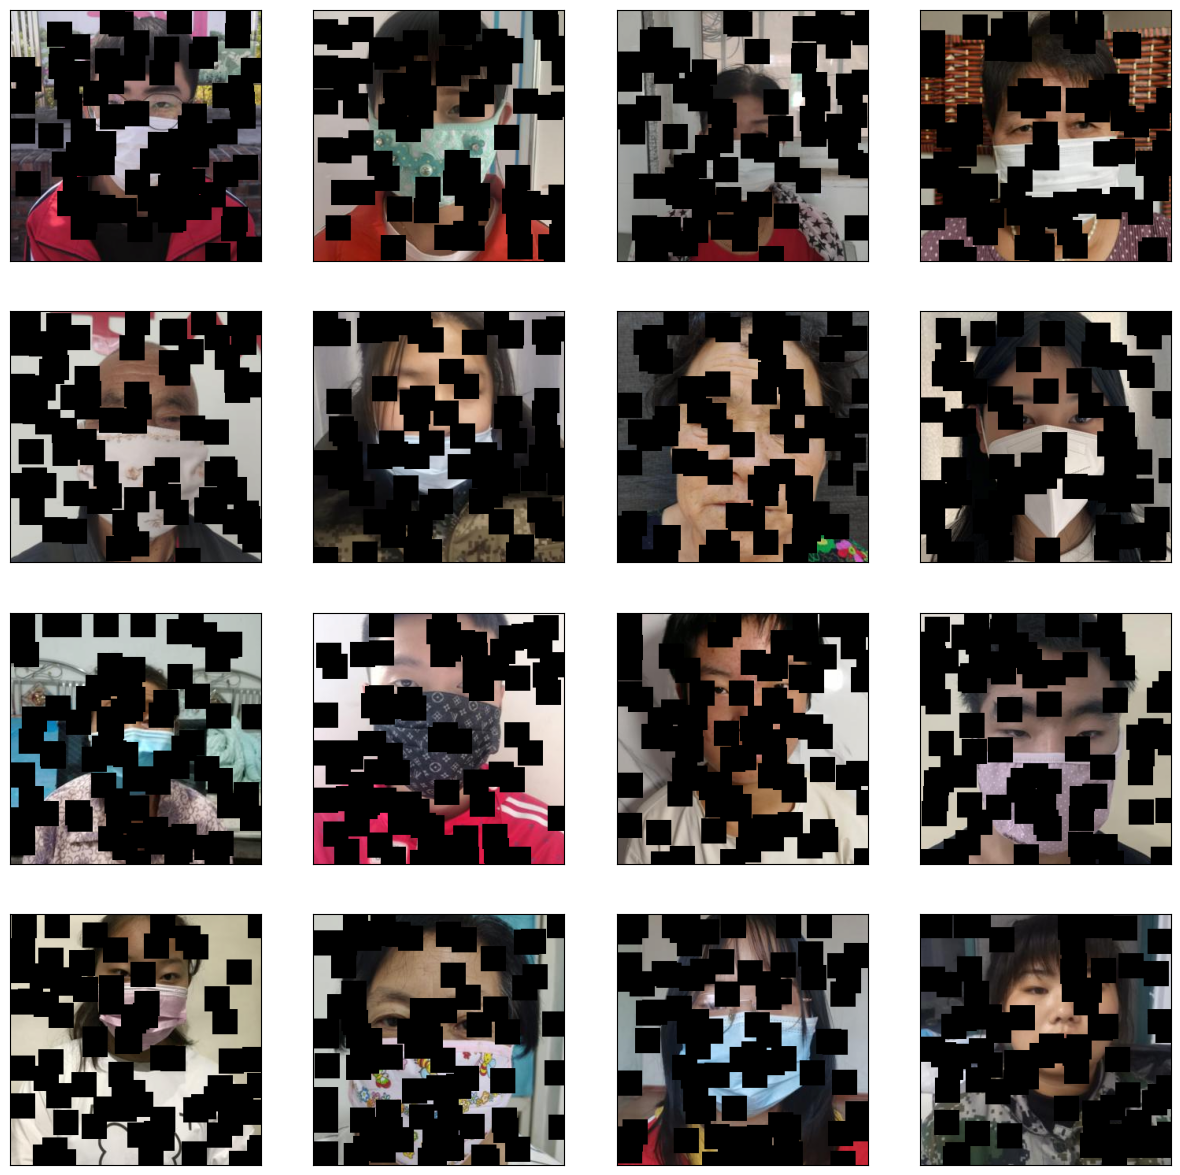

In [32]:
img, labels = next(iter(train_dataloader))

mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

for i in range(3):
    img[:, i, ...] = img[:, i, ...] * std[i] + mean[i]

fig, axes = plt.subplots(figsize=(15, 15), nrows=4, ncols=4)


for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].permute(1, 2, 0).numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Train

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction="mean"):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction,
        )

mask_criterion = FocalLoss(weight=torch.tensor([0.2857142857142857, 0.8571428571428571, 0.8571428571428571]).to(device))
gender_criterion = FocalLoss(weight=torch.tensor([0.3859259259259259, 0.614074074074074]).to(device))
age_criterion = FocalLoss(weight=torch.tensor([0.5255555555555556, 0.5455555555555556, 0.9288888888888889]).to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
model = model.to(device)

os.makedirs("check_point", exist_ok=True)

In [20]:
log_loss = []

for epoch in range(51):
    model.train()
    correct_mask = torch.zeros(3)
    correct_gender = torch.zeros(2)
    correct_age = torch.zeros(3)
    with tqdm(train_dataloader) as pbar:
        pbar.set_description(f"Epoch : {epoch}")
        sum_loss = 0
        sum_mask_acc = 0
        sum_gender_acc = 0
        sum_age_acc = 0
        sum_len = 0
        sum_score_mask = 0
        sum_score_gender = 0
        sum_score_age = 0
        for imgs, labels in pbar:
            imgs, (mask_label, gender_label, age_label) = imgs.to(device), labels
            mask_label = mask_label.to(device)
            gender_label = gender_label.to(device)
            age_label = age_label.to(device)
            
            optimizer.zero_grad()
            
            pred = model(imgs)
            (mask, gender, age) = torch.split(pred, [3, 2, 3], dim=1)
            
            mask_loss = mask_criterion(mask, mask_label)
            gender_loss = gender_criterion(gender, gender_label)
            age_loss = age_criterion(age, age_label)
            
            _, mask_idx = torch.max(mask, dim=1)
            _, gender_idx = torch.max(gender, dim=1)
            _, age_idx = torch.max(age, dim=1)
            
            loss = mask_loss + gender_loss + age_loss
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            sum_mask_acc += torch.sum(mask_idx == mask_label).item()
            sum_gender_acc += torch.sum(gender_idx == gender_label).item()
            sum_age_acc += torch.sum(age_idx == age_label).item()
            sum_len += imgs.size(0)

            sum_score_mask += f1_score(mask_idx.detach().cpu(), mask_label.detach().cpu(), average='macro')
            sum_score_gender += f1_score(gender_idx.detach().cpu(), gender_label.detach().cpu(), average='macro')
            sum_score_age += f1_score(age_idx.detach().cpu(), age_label.detach().cpu(), average='macro')
            
            mask_unique, correct_mask_cnt = torch.unique(mask_idx[mask_idx == mask_label].detach().cpu(), return_counts=True)
            for i, n in zip(mask_unique, correct_mask_cnt):
                correct_mask[i] += n
                
            gender_unique, correct_gender_cnt = torch.unique(gender_idx[gender_idx == gender_label].detach().cpu(), return_counts=True)
            for i, n in zip(gender_unique, correct_gender_cnt):
                correct_gender[i] += n
                
            age_unique, correct_age_cnt = torch.unique(age_idx[age_idx == age_label].detach().cpu(), return_counts=True)
            for i, n in zip(age_unique, correct_age_cnt):
                correct_age[i] += n
            
            pbar.set_postfix(train_loss=f"{sum_loss / sum_len:.3f}", mask_acc=f"{sum_mask_acc / sum_len:.3f}", gender_acc=f"{sum_gender_acc / sum_len:.3f}", age_acc=f"{sum_age_acc / sum_len:.3f}", f1_mask=f"{sum_score_mask / len(train_dataloader):.3f}", f1_gender=f"{sum_score_gender / len(train_dataloader):.3f}", f1_age=f"{sum_score_age / len(train_dataloader):.3f}")
            
        log_loss.append(sum_loss / sum_len)
        
    print(f"mask : {correct_mask / mask_cnt} | gender : {correct_gender / gender_cnt} | age : {correct_age / age_cnt}")
    
    if epoch % 5 == 0:
        torch.save(model.state_dict(), "check_point/model_" + str(epoch) + ".pth")

Epoch : 0:   8%|▊         | 25/296 [00:26<04:45,  1.05s/it, age_acc=0.657, f1_age=0.036, f1_gender=0.036, f1_mask=0.029, gender_acc=0.641, mask_acc=0.734, train_loss=0.015]


KeyboardInterrupt: 

In [1]:
from model.model import ResNet
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import timm
from tqdm import tqdm
import numpy as np
from PIL import Image
import os

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class TestDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform
    
    def __getitem__(self, idx):
        
        if self.transform != None:
            image = self.transform(image=np.array(Image.open(self.images[idx])))
        
        return image["image"]
    
    def __len__(self):
        return len(self.images)

test_transform = A.Compose([
    A.CenterCrop(320, 320, p=1),
    A.Normalize(p=1),
    ToTensorV2()
])

submission = pd.read_csv('/opt/ml/input/data/eval/info.csv')
image_dir = '/opt/ml/input/data/eval/images'

image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

model = timm.create_model('resnet18', pretrained=True, num_classes=8)
model.load_state_dict(torch.load("/opt/ml/code/check_point/model_50.pth"))
model = model.to(device)
model.eval()

# model = ResNet(3, 64, 8, drop_ratio=0)
# model.load_state_dict(torch.load("/opt/ml/WorkSpace/level1_imageclassification-cv-20/check_point/model_35.pth"))
# model = model.to(device)
# model.eval()

submission = pd.read_csv('/opt/ml/input/data/eval/info.csv')
all_predictions = []
with torch.no_grad():
    with tqdm(test_dataloader) as pbar:
        for images in pbar:
            images = images.to(device)
            
            pred = model(images)
            
            (mask, gender, age) = torch.split(pred, [3, 2, 3], dim=1)
            
            _, mask_idx = torch.max(mask, dim=1)
            _, gender_idx = torch.max(gender, dim=1)
            _, age_idx = torch.max(age, dim=1)
            
            label = (mask_idx * 6) + (gender_idx * 3) + age_idx
            
            all_predictions.extend(label.cpu().numpy())
            
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv('/opt/ml/code/submission.csv', index=False)
print('test inference is done!')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 12600/12600 [01:51<00:00, 112.62it/s]


test inference is done!
